In [1]:
import pandas as pd
import numpy as np
import gutenbergpy.textget
import re
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize
from plotnine import *

In [2]:
book_authors = {
    'Charles Dickens': [46, 98, 1400, 730, 766, 1023, 786, 580, 883],
    'Herman Melville': [2701, 11231, 15859, 21816, 34970, 10712, 12384, 4045, 8118, 2694, 13720, 53861],
    'Jane Austen': [1342, 158, 161, 105, 121, 141, 946]
}

In [3]:
book_contents = {}
for book_id in [book_id for id_list in book_authors.values() for book_id in id_list]:
    # Load in the book
    raw_book = gutenbergpy.textget.get_text_by_id(book_id)
    clean_book = gutenbergpy.textget.strip_headers(raw_book)
    # Convert to string
    book = clean_book.decode('UTF-8')
    # Remove first characters of the book (remove chapter headings, etc)
    #book = book[10000:]
    # Choose a random sample within the book
    #rng = np.random.default_rng(1000)
    #rng.random() * (len(book_contents) - 1000)
    #start_value = len(book_contents)
    #book_contents = book_contents[np.random]
    book_contents[book_id] = book


In [4]:
books_wtoks = {}
books_stoks = {}
for book_id, book in book_contents.items():
    books_wtoks[book_id] = word_tokenize(book)
    books_stoks[book_id] = sent_tokenize(book)

In [5]:
book_stats = {}
for book_id in book_contents.keys():
    book_stats[book_id] = {}
    book_stok = books_stoks[book_id]
    book_wtok = books_wtoks[book_id]
    (book_stats[book_id])['sent_chars'] = [len(sent) for sent in book_stok]
    (book_stats[book_id])['sent_words'] = [len(word_tokenize(sent)) for sent in book_stok]
    (book_stats[book_id])['word_chars'] = [len(word) for word in book_wtok]

In [12]:
# Convert to data frames
stat_dfs = {}
stat_names = book_stats[list(book_stats.keys())[0]]
for stat_name in stat_names:
    stat_data = {book_id:book_stat[stat_name] for book_id, book_stat in book_stats.items()}
    stat_data_df = pd.DataFrame.from_dict({k: pd.Series(v) for k, v in stat_data.items()}, orient='columns')
    stat_data_df_long = pd.melt(stat_data_df).dropna(how='any')
    stat_data_df_long.columns = ['book_id', stat_name]
    book_authors_df = pd.melt(pd.DataFrame.from_dict({k:pd.Series(v) for k, v in book_authors.items()}))
    book_authors_df.columns = ['author_name', 'book_id']
    stat_df_final = stat_data_df_long.merge(book_authors_df, on='book_id', how='left')
    stat_df_final = stat_df_final.sort_values('author_name')
    stat_dfs[stat_name] = stat_df_final

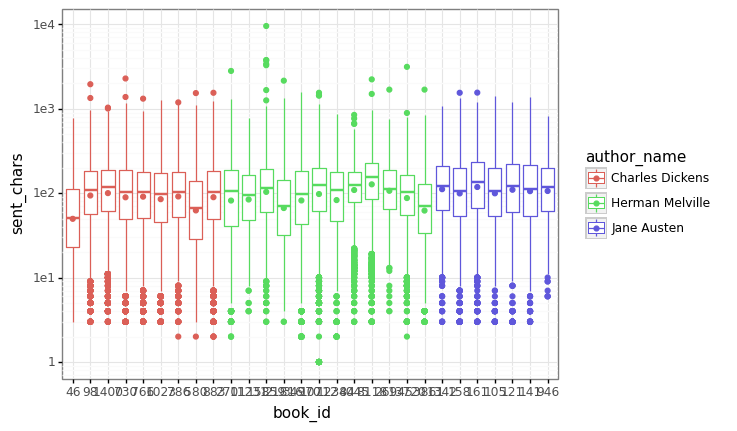

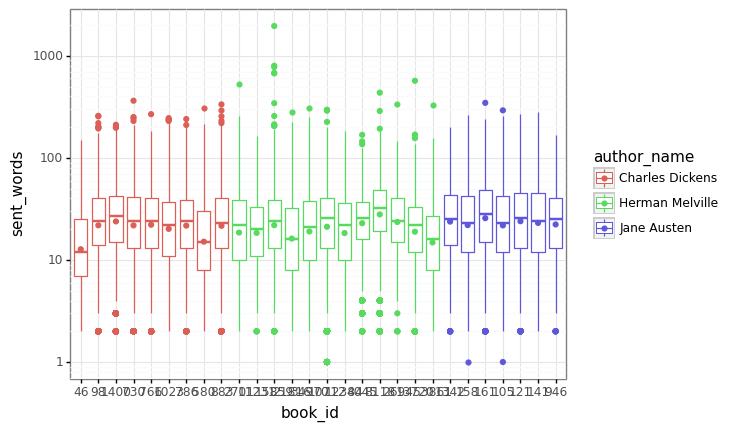

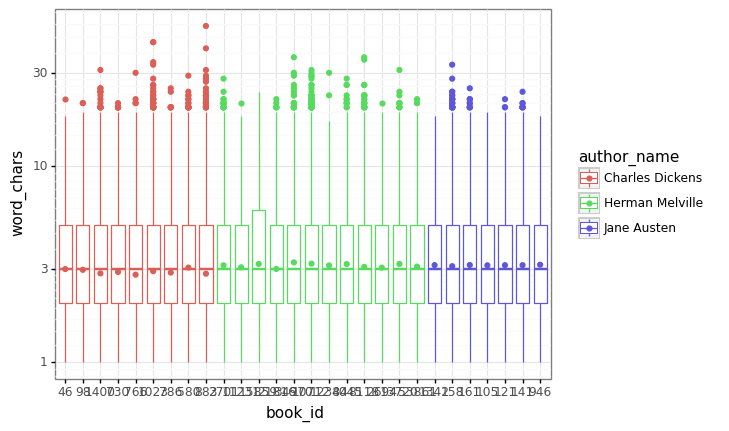

In [40]:
for plot_var in stat_dfs.keys():
    graph_df = stat_dfs[plot_var]
    graph_df['book_id'] = pd.Categorical(graph_df['book_id'])
    book_order = book_authors['Charles Dickens'] + book_authors['Herman Melville'] + book_authors['Jane Austen']
    plot = (
        ggplot(stat_dfs[plot_var], aes(x='book_id', y=plot_var, color='author_name'))
        + geom_boxplot()
        + scale_y_log10()
        + stat_summary(fun_y=np.mean, geom='point')
        + scale_x_discrete(limits=book_order)
        + theme_bw()
        + theme(axis_text_x=element_text(rotation=90, hjust=1))
    )
    plot.draw(show=True)


In [65]:
book_grams = {}
for author, books in book_authors.items():
    for book_id in books:
        #book = book_contents[book_id]
        top_grams = pd.Series(sorted(ngrams(books_wtoks[book_id], 3))).value_counts()
        book_grams[book_id] = top_grams


In [84]:
author_ngs = {}
for author, books in book_authors.items():
    ng_df = pd.DataFrame(book_grams[books[0]]).reset_index()
    ng_df.columns = ['ng', f'count_{books[0]}']
    for book_id in books[1:]:
        new_ng_df = pd.DataFrame(book_grams[book_id]).reset_index()
        new_ng_df.columns = ['ng', f'count_{book_id}']
        ng_df = ng_df.merge(new_ng_df, on='ng')
    author_ngs[author] = ng_df

In [87]:
author_ngs['Jane Austen'].head(20)

,ng,count_1342,count_158,count_161,count_105,count_121,count_141,count_946
0,"(,, ”, said)",217,225,213,75,92,217,11
1,"(?, ”, “)",168,147,147,49,148,107,7
2,"(”, “, I)",130,138,104,34,70,105,4
3,"(,, however, ,)",111,89,94,56,79,93,24
4,"(;, and, ,)",105,53,18,22,67,42,8
5,"(,, and, the)",88,89,87,53,65,140,8
6,"(., It, was)",77,117,57,67,41,110,2
7,"(,, my, dear)",71,82,40,14,32,47,30
8,"(., “, I)",70,79,63,31,34,73,2
9,"(,, I, am)",69,78,33,24,35,51,18


In [71]:
df1 = pd.DataFrame(book_grams[46]).reset_index()
df2 = pd.DataFrame(book_grams[98]).reset_index()
df1.merge(df2, on='index').head(30)


,index,0_x,0_y
0,"(., It, was)",31,75
1,"(,, and, the)",29,207
2,"(,, as, if)",20,52
3,"(it, ,, and)",15,61
4,"(., He, was)",15,39
5,"(,, that, he)",14,48
6,"(that, it, was)",13,25
7,"(,, in, the)",13,81
8,"(it, was, a)",12,23
9,"(would, have, been)",12,25


In [50]:
contents = book_contents[98][5000:10000]
contents_tok = word_tokenize(contents)
np.mean([len(word) for word in contents_tok])

4.09919028340081

In [90]:
pd.melt(df)

,variable,value
0,46,1.0
1,46,9.0
2,46,5.0
3,46,2.0
4,46,5.0
...,...,...
12421215,946,NaN
12421216,946,NaN
12421217,946,NaN
12421218,946,NaN


In [ ]:
sorted(grams)[0:10]

In [ ]:
list(grams)
new_grams = grams.copy()
gram_count = {}
for i in range(0, len(grams)-1):
    gram = new_grams.pop(0)
    if gram in new_grams:
        if gram not in gram_count:
            gram_count[gram] = 0
        gram_count[gram] += 1

In [ ]:
dict(sorted(gram_count.items(), key=lambda item: -item[1]))

In [24]:
sorted(ngrams(books_wtoks[98], 3))

[('!', ')', ','),
 ('!', ')', ','),
 ('!', '*', '*'),
 ('!', '--', 'A'),
 ('!', '--', 'And'),
 ('!', '--', 'And'),
 ('!', '--', 'And'),
 ('!', '--', 'Don'),
 ('!', '--', 'I'),
 ('!', '--', 'I'),
 ('!', '--', 'Joe'),
 ('!', '--', 'Look'),
 ('!', '--', 'always'),
 ('!', '--', 'beats'),
 ('!', '--', 'much'),
 ('!', '--', 'perhaps'),
 ('!', '--', 'to'),
 ('!', '--', 'under'),
 ('!', '--', 'we'),
 ('!', '--', '”'),
 ('!', 'A', 'bitter'),
 ('!', 'A', 'brave'),
 ('!', 'A', 'child'),
 ('!', 'A', 'good'),
 ('!', 'A', 'good'),
 ('!', 'A', 'moment'),
 ('!', 'A', 'plot'),
 ('!', 'A', 'serf'),
 ('!', 'About', 'two'),
 ('!', 'Again', '?'),
 ('!', 'All', 'is'),
 ('!', 'Almost', 'a'),
 ('!', 'And', 'Evrémonde'),
 ('!', 'And', 'O'),
 ('!', 'And', 'hallo'),
 ('!', 'And', 'if'),
 ('!', 'And', 'it'),
 ('!', 'And', 'off'),
 ('!', 'And', 'off'),
 ('!', 'And', 'off'),
 ('!', 'And', 'you'),
 ('!', 'Any', 'one'),
 ('!', 'Any', 'person'),
 ('!', 'Armed', 'men'),
 ('!', 'As', 'if'),
 ('!', 'As', 'to'),
 ('!', 'A